# Notebook de diseño de la Red Predictiva Fintech_LSTM

### Celdas de carga de librerías, paquetes, etc...

In [1]:
####################################################################################
# PASO 1: Importar todos los módulos necesarios
import sys
ENABLE_GOOGLE_COLAB = 'google.colab' in sys.modules
ENABLE_GOOGLE_COLAB

False

In [2]:
####################################################################################
if ENABLE_GOOGLE_COLAB:
  # Instalación de API de Google Drive para utilizar archivos en la nube
  !pip install -U -q PyDrive
  # Instala h5py
  !pip install h5py
  # Instala plot.ly
  !pip install plotly
  # TA-Lib: instalación y carga de la librería
  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  !make
  !make install
  !pip install Ta-Lib
  # Instalación de ngrok para visualización en tensorboard
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip
  from google.colab import auth
  from google.colab import files
  
####################################################################################
# incluye google drive api
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

####################################################################################
# Librerías de manejo de datos 
import pandas as pd
from pandas import concat
import numpy as np

####################################################################################
# Librerías de machine learning
import sklearn
from sklearn import preprocessing
from sklearn import metrics as sk
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

####################################################################################
# Librerías de visualización
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
from matplotlib.dates import (MONDAY, DateFormatter, MonthLocator, WeekdayLocator, date2num)
import matplotlib as mpl
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
tls.set_credentials_file(username='raulMrello', api_key='qX9S30YRQ866mGF9b89u')

####################################################################################
# TA-Lib: instalación y carga de la librería
import talib

####################################################################################
# Otras utilidades
import datetime
import time
import os
import sys
import math

####################################################################################
print('Done!')

Using TensorFlow backend.


Done!


In [3]:
####################################################################################
# PASO 2a (google colab): Autenticación en Google Drive para obtener el archivo csv
if ENABLE_GOOGLE_COLAB:
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  #2. Obtiene el archivo
  downloaded = drive.CreateFile({'id':'12syio4J4xs-PFo_qNNWsNKvQhZb0nOaY'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('EURUSD_H1.csv')  
  #downloaded = drive.CreateFile({'id':'1xuDgK4FteolMBiaYVRNWaofw36iQyRaV'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('EURUSD_M30.csv')  
  #downloaded = drive.CreateFile({'id':'18o564BOnayxVbbY2DR7BjGXY-zzk9PBd'}) # replace the id with id of file you want to access
  #downloaded.GetContentFile('test_fourier.csv')  

### Celdas de carga de datos históricos desde archivo csv a Pandas Dataframe

- Cargo el histórico en dataframe
- Puedo reindexar el timestamp a una cadencia fija (ej. 1 hora) y rellenar los gaps (NaN)
- Puedo visualizar el resultado en forma de gráfico de velas

         DATE      TIME    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0  2001.01.01  00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1  2001.01.01  08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2  2001.01.01  14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3  2001.01.01  15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4  2001.01.01  18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
            timestamp    OPEN    HIGH     LOW   CLOSE  TICKVOL  VOL  SPREAD
0 2001-01-01 00:00:00  0.9421  0.9423  0.9419  0.9419        5    0      50
1 2001-01-01 08:00:00  0.9422  0.9424  0.9422  0.9424        2    0      50
2 2001-01-01 14:00:00  0.9425  0.9425  0.9425  0.9425        1    0      50
3 2001-01-01 15:00:00  0.9419  0.9419  0.9419  0.9419        1    0      50
4 2001-01-01 18:00:00  0.9397  0.9399  0.9390  0.9395       20    0      50 
--------------------------
                    

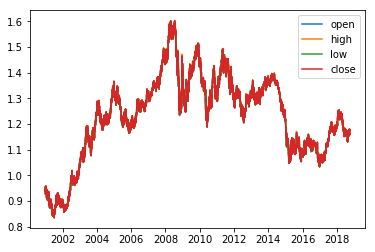

In [4]:
####################################################################################
# PASO 3: Carga el archivo csv en un dataframe, con posibilidad de rellenar espacios vacíos
def load_hist(filename, **kwargs):
    '''
        :param filename Archivo csv a leer
        :param kwargs lista de opciones:
            sep CSV Separator
            reindex_fillna Flag para rellenar espacios en blanco
            plot_it Flag para visualizar el archivo
        :return dataframe creado
    '''
    sep = ','
    reindex_fillna=False
    plot_it=False    
    if kwargs is not None:
        for key, value in kwargs.items():
            if key == 'sep': sep = value
            if key == 'reindex_fillna': reindex_fillna = value
            if key == 'plot_it': plot_it = value
                
    df = pd.read_csv(filename, sep=sep) 
    print(df.head(),'\r\n--------------------------')
    # crea una nueva columna de timestamp uniendo date & time y crea columnas para el día de la semana, el día del mes, el mes y la hora del día actual 
    df['timestamp'] = df['DATE'] + '  ' + df['TIME'] 
    df['timestamp'] = df['timestamp'].map(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))  
    df['weekday'] = df['timestamp'].map(lambda x: x.dayofweek) 
    df['day'] = df['timestamp'].map(lambda x: x.day) 
    df['month'] = df['timestamp'].map(lambda x: x.month) 
    df['hhmm'] = df['timestamp'].map(lambda x: x.hour*60 + x.minute) 
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df[['timestamp','OPEN','HIGH','LOW','CLOSE','TICKVOL','VOL','SPREAD']]
    print(df.head(),'\r\n--------------------------')
    # establece como índice la columna de timestamp con una cadencia de 30min para encontrar los valores NaN
    if reindex_fillna:
        df.set_index('timestamp', inplace=True)
        df = df.reindex(pd.date_range(min(df.index), max(df.index), freq="1H"))
        # elimina los valores nulos y los rellena con el valor anterior
        df.fillna(method='ffill', inplace =True)
        print(df.head())
    if plot_it:
        plt.plot(df.OPEN)
        plt.plot(df.HIGH)
        plt.plot(df.LOW)
        plt.plot(df.CLOSE)
        plt.legend(['open','high','low','close'], loc='upper right')        
    return df
        
    
####################################################################################
####################################################################################

df = load_hist('EURUSD_H1.csv',sep=';', reindex_fillna=True, plot_it=True)    

# visualizo una sección
trace = go.Candlestick(x=df.index[-100:],
                               open=df.OPEN[-100:],
                               high=df.HIGH[-100:],
                               low=df.LOW[-100:],
                               close=df.CLOSE[-100:])
data = [trace]
layout = go.Layout(
    autosize=False,
    width=1000,
    height=700,    
    title='Mostrando últimos 100 datos',
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

###  Elaboración de indicadores técnicos sintéticos

A partir de los datos OHLC, y la librería TA-Lib genero diversos indicadores sintéticos. En este caso he optado por predecir el precio de cierre 'close' y por lo tanto, todos los indicadores se aplicarán a dicho precio (aunque se podrían utilizar otros precios como 'high', 'low', 'open', etc...).

- bollWidthRel: Aporta la anchura de las bandas bollinger relativa a su propia SMA100
- bollR: Aporta la posición del precio en relación a la banda bollinger en %
- atr: Aporta la diferencia entre éste y el cierre de la sesión anterior
- SMAx3: Aporta 3 medias simples de 4,16 y 40 periodos
- Además también puedo añadir el propio precio ('close')

,bollWidthRel_CLOSE,bollR_CLOSE,atr_CLOSE,sma4_CLOSE,sma16_CLOSE,sma40_CLOSE,CLOSE,out
2001-01-03 20:00:00,0.863983,-0.247251,-0.001500,0.938950,0.948537,0.947213,0.9297,0.9297
2001-01-03 21:00:00,0.984695,-0.109007,-0.001579,0.934300,0.947169,0.946955,0.9290,0.9290
2001-01-03 22:00:00,1.068522,-0.048342,-0.001621,0.929825,0.945694,0.946655,0.9271,0.9271
2001-01-03 23:00:00,1.100524,0.042001,-0.001871,0.928350,0.944225,0.946383,0.9276,0.9276
2001-01-04 00:00:00,1.095071,0.118506,-0.001843,0.928075,0.942900,0.946040,0.9286,0.9286


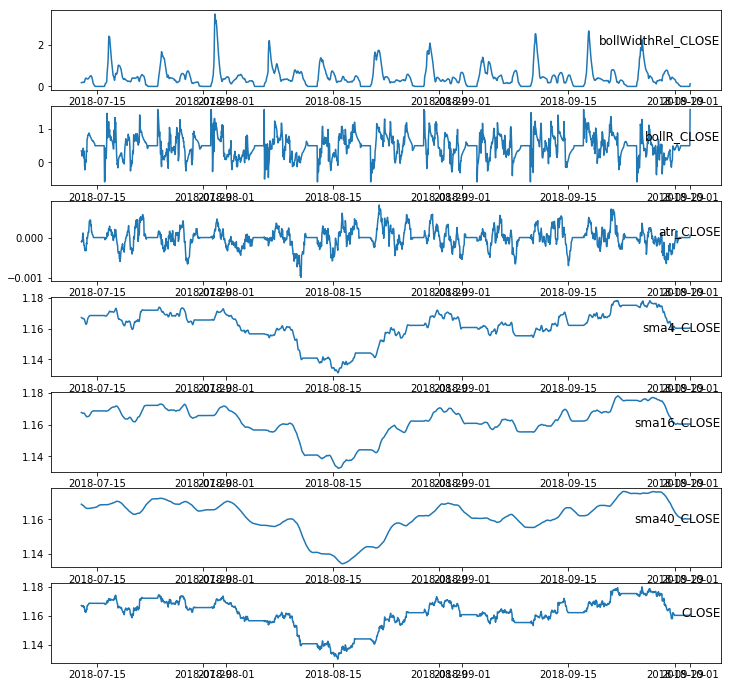

In [5]:
####################################################################################
# PASO 4: Crea columnas para diferentes indicadores TA-Lib, descarta el resto de columnas
def add_indicators(df, applied, indicators, **kwargs):
    '''
        :param df DataFrame de referencia
        :param applied Lista de precios a los que aplicar los indicadores
        :param indicators Lista de los indicadores a formar:
                    bollWidthRel - Anchura bandas bollinger relativa a la sma100 de la anchura
                    bollR - Posición del precio en la banda en %
                    atr - Average true range standar
                    SMAx3 - Triple media móvil superpuestas dos a dos
                    CLOSE - Datos en columna df.CLOSE
        :return dataframe actualizado
    '''
    df = df.copy()    
    cols = list()
    for p in applied:
        if df[p] is None: continue
        upperband, middleband, lowerband = talib.BBANDS(df[p], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        bollinger_width = upperband - lowerband
        sma8 = talib.SMA(df[p], timeperiod=8)
        sma50 = talib.SMA(df[p], timeperiod=50)
        sma100 = talib.SMA(df[p], timeperiod=100)    
        for i in indicators:
            if i+'_'+p in df.columns:
                continue                
            if i=='bollWidthRel':
                # obtengo columnas a partir de features TA-Lib            
                bollinger_width_sma50 = talib.SMA(bollinger_width, timeperiod=50)            
                df[i+'_'+p] = bollinger_width/(3*bollinger_width_sma50)
                cols.append(i+'_'+p)
                
            elif i=='bollR':
                if i+'_'+p in df.columns:
                    continue                
                bollR = (df[p] - lowerband)/(upperband - lowerband)
                bollR[np.isnan(bollR)]=0.5
                bollR[np.isinf(bollR)]=0.5
                df[i+'_'+p]=bollR
                cols.append(i+'_'+p)
                
            elif i=='atr':
                df[i+'_'+p] = talib.SMA((df[p] - df.CLOSE.shift(1)),timeperiod=14)
                cols.append(i+'_'+p)
              
            elif i=='SMAx3':            
                df['sma4_'+p] = talib.SMA(df.CLOSE,timeperiod=4)
                df['sma16_'+p] = talib.SMA(df.CLOSE,timeperiod=16)
                df['sma40_'+p] = talib.SMA(df.CLOSE,timeperiod=40)
                cols.append('sma4_'+p)
                cols.append('sma16_'+p)
                cols.append('sma40_'+p)
              
            elif i=='HIGH' or i=='LOW' or i== 'CLOSE' or i=='OPEN':
                if i in cols:
                    continue                
                cols.append(i)
                
            else:  
                print('Indicador "{}" desconocido'.format(i))
    
    
    plot_it = False
    starts = 0    
    plot_len = 0
    for key,val in kwargs.items():        
        if key=='plot_it': plot_it=val
        elif key=='starts': starts=val
        elif key=='plot_len': plot_len=val
        elif key=='add_applied':
            for i in applied:
                cols.append(i)
    
    df.dropna(inplace=True)    
    df = df[cols]
    if plot_it:
        plt.figure(figsize=(12,12))
        for i in cols:
            plt.subplot(len(cols), 1, cols.index(i)+1)
            plt.plot(df[i][starts:starts+plot_len])
            plt.title(i, y=0.5, loc='right')
    return df

####################################################################################
####################################################################################

dfapp = add_indicators(df, ['CLOSE'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True, plot_it=True, starts=df.shape[0]-2000, plot_len=2000)
dfapp['out'] = dfapp['CLOSE']
dfapp.head()



###  Adaptación de los datos para realizar un entrenamiento supervisado 

Los datos vienen dados para cada timestamp, sin embargo la red neuronal espera un formato distinto, del tipo:

x: (num_samples, loopback_wdow, num_inputs)
y: (num_outputs * forecast_wdow)

En este caso, las entradas van a ser los diferentes indicadores aplicados al precio 'close' y las salidas serán las predicciones para ese precio 'close':

- Se utilizarán datos de las últimas 24 sesiones y se predecirán los de las 4 siguientes
- Las entradas serán cada uno de los indicadores anteriores, además del precio.
- La salida será la predicción del precio para esas 4 sesiones

In [6]:
####################################################################################
# PASO 5: Crea time-steps de las entradas y las salidas para la red LSTM
def series_to_supervised(df, num_inputs, num_outputs, n_in=1, n_out=1, dropnan=True):
  # obtengo el dataframe con las entradas y las salidas
  df_in = df[[x for x in df.columns if df.columns.get_loc(x) < num_inputs]]
  df_out = df[[x for x in df.columns if df.columns.get_loc(x)>=num_inputs]]
  
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in-1, -1, -1):
    cols.append(df_in.shift(i))
    if i!=0:
      names += [('%s(t-%d)' % (df_in.columns[j], i)) for j in range(0, num_inputs)]
    else:
      names += [('%s(t)' % (df_in.columns[j])) for j in range(0, num_inputs)]
    
	# forecast sequence (t, t+1, ... t+n)
  for i in range(1, n_out+1):   
    cols.append(df_out.shift(-i))
    if i == 0:
      names += [('%s(t)' % (df_out.columns[j])) for j in range(0, num_outputs)]
    else:
      names += [('%s(t+%d)' % (df_out.columns[j], i)) for j in range(0, num_outputs)]
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

####################################################################################
####################################################################################

# Creo columnas para las 24 muestras de entradas t-1, ..., t-48 y para las dos salidas t, t+1
num_in_steps = 24
num_out_steps = 4
num_outputs = 1
num_inputs = dfapp.shape[1] - num_outputs
sts_df = series_to_supervised(dfapp, num_inputs, num_outputs, num_in_steps, num_out_steps)
print('Número de muestras total: ', sts_df.shape[0])
sts_df.head()

Número de muestras total:  155464


,bollWidthRel_CLOSE(t-23),bollR_CLOSE(t-23),atr_CLOSE(t-23),sma4_CLOSE(t-23),sma16_CLOSE(t-23),sma40_CLOSE(t-23),CLOSE(t-23),bollWidthRel_CLOSE(t-22),bollR_CLOSE(t-22),atr_CLOSE(t-22),...,bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2),out(t+3),out(t+4)
2001-01-04 19:00:00,0.863983,-0.247251,-0.001500,0.938950,0.948537,0.947213,0.9297,0.984695,-0.109007,-0.001579,...,0.802584,0.001386,0.946650,0.942625,0.942763,0.9500,0.9503,0.9496,0.9501,0.9510
2001-01-04 20:00:00,0.984695,-0.109007,-0.001579,0.934300,0.947169,0.946955,0.9290,1.068522,-0.048342,-0.001621,...,0.783738,0.001500,0.948075,0.943869,0.942755,0.9503,0.9496,0.9501,0.9510,0.9535
2001-01-04 21:00:00,1.068522,-0.048342,-0.001621,0.929825,0.945694,0.946655,0.9271,1.100524,0.042001,-0.001871,...,0.738469,0.001243,0.949300,0.945056,0.942723,0.9496,0.9501,0.9510,0.9535,0.9531
2001-01-04 22:00:00,1.100524,0.042001,-0.001871,0.928350,0.944225,0.946383,0.9276,1.095071,0.118506,-0.001843,...,0.732781,0.000429,0.950000,0.946356,0.942708,0.9501,0.9510,0.9535,0.9531,0.9534
2001-01-04 23:00:00,1.095071,0.118506,-0.001843,0.928075,0.942900,0.946040,0.9286,1.064460,0.185682,-0.001900,...,0.742542,0.000386,0.950250,0.947531,0.942705,0.9510,0.9535,0.9531,0.9534,0.9536


In [7]:
####################################################################################
# PASO 6: Aplicar lo que se necesite a las salidas o no hacer nada en caso contrario
sts_src = sts_df.copy()
# sts_src contiene el dataframe original sin escalado y con todas las columnas más representativas

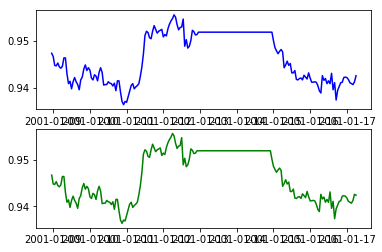

In [8]:
####################################################################################
# PASO 7: Chequeo de los datos antes de su selección y normalización para la red neuronal 
i,j=100,300
plt.subplot(2,1,1)
plt.plot(sts_src['CLOSE(t)'][i:j],color='b')
plt.subplot(2,1,2)
plt.plot(sts_src['out(t+1)'][i:j],color='g')



### Normalización de los datos de entrada-salida

A continuación, se realiza la selección final de columnas del dataframe que se utilizará en la red neuronal y los datos se normalizarán utilizando un 'scaler' concreto. Dicho scaler se utilizará tras el proceso de predicción, para volver a de-normalizar el resultado y obtener su valor real.

In [9]:
####################################################################################
# PASO 8: Selecciono las columnas que se utilizarán en la red neuronal (para normalizarse)


In [10]:
####################################################################################
# PASO 9: Creo los scalers de cada columna seleccionada
values = sts_src.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
values = scaler.fit_transform(values)

# actualizo el dataframe
sts_scaled = pd.DataFrame(data=values, columns=sts_src.columns, index=sts_src.index)
sts_values = sts_scaled.values
sts_scaled.head()


,bollWidthRel_CLOSE(t-23),bollR_CLOSE(t-23),atr_CLOSE(t-23),sma4_CLOSE(t-23),sma16_CLOSE(t-23),sma40_CLOSE(t-23),CLOSE(t-23),bollWidthRel_CLOSE(t-22),bollR_CLOSE(t-22),atr_CLOSE(t-22),...,bollR_CLOSE(t),atr_CLOSE(t),sma4_CLOSE(t),sma16_CLOSE(t),sma40_CLOSE(t),CLOSE(t),out(t+1),out(t+2),out(t+3),out(t+4)
2001-01-04 19:00:00,-0.896322,-0.685715,-0.531823,-0.730614,-0.706189,-0.715587,-0.754537,-0.881837,-0.558871,-0.555556,...,0.277554,0.339806,-0.710451,-0.721707,-0.727374,-0.701528,-0.700744,-0.702572,-0.701266,-0.698916
2001-01-04 20:00:00,-0.881837,-0.558871,-0.555556,-0.742791,-0.709782,-0.716269,-0.756365,-0.871777,-0.503208,-0.568501,...,0.260262,0.374326,-0.706720,-0.718443,-0.727394,-0.700744,-0.702572,-0.701266,-0.698916,-0.692388
2001-01-04 21:00:00,-0.871777,-0.503208,-0.568501,-0.754509,-0.713653,-0.717064,-0.761327,-0.867937,-0.420314,-0.644013,...,0.218726,0.296656,-0.703512,-0.715326,-0.727480,-0.702572,-0.701266,-0.698916,-0.692388,-0.693432
2001-01-04 22:00:00,-0.867937,-0.420314,-0.644013,-0.758371,-0.717508,-0.717786,-0.760021,-0.868592,-0.350117,-0.635383,...,0.213507,0.050701,-0.701679,-0.711914,-0.727520,-0.701266,-0.698916,-0.692388,-0.693432,-0.692649
2001-01-04 23:00:00,-0.868592,-0.350117,-0.635383,-0.759091,-0.720986,-0.718693,-0.757409,-0.872265,-0.288480,-0.652643,...,0.222463,0.037756,-0.701025,-0.708830,-0.727527,-0.698916,-0.692388,-0.693432,-0.692649,-0.692127


In [83]:
# guardo el scaler en disco

from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 


['scaler.save']

<Figure size 432x288 with 0 Axes>

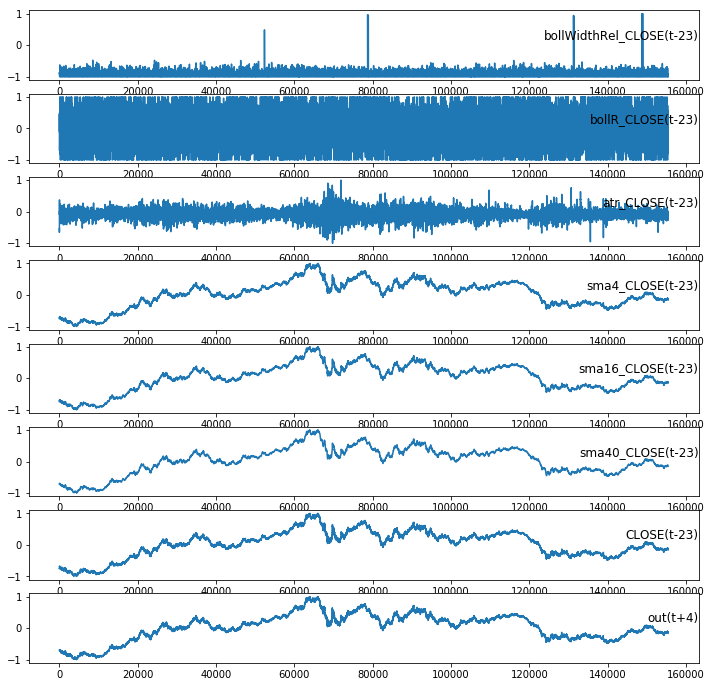

In [11]:
####################################################################################
# PASO 10 (opcional): Visualización de entradas y salidas escaladas
plt.figure()
plots = num_inputs + num_outputs
plt.figure(figsize=(12,12))
for col in range(num_inputs):
  plt.subplot(plots, 1, col+1)
  plt.plot(values[:, col])
  plt.title(sts_scaled.columns[col], y=0.5, loc='right')
for col in range(num_outputs):
  plt.subplot(plots, 1, num_inputs+col+1)
  plt.plot(values[:, -num_outputs+col])
  plt.title(sts_scaled.columns[-num_outputs+col], y=0.5, loc='right')


### Preparación de los pares entrenamiento-validación y test

El dataframe normalizado 'sts_scaled' se divide en dos grupos:     |------ train&validate------|-- test --|
A continuación se calculan los tamaños de las ventanas de walk-forward:

|--------- wdow_train_validate ---------|
|----- wdow_train -----|-- wdow_valid --|
        |----- wdow_train -----|-- wdow_valid --|
                |----- wdow_train -----|-- wdow_valid --|
                        ...


In [12]:
# establece un batch_size para que todo sea un múltiplo de éste
batch_size = 64
# establezco un ratio train-validation de (80%, 20%), para lo que tomo bloques de 5 batches: 4-train 1-validate
wf_train = 4 * batch_size
wf_validate = 1 * batch_size
# calculo el número de muestras train-validate para que sea un múltiplo entero de 5 batches
wf_forward = wf_train + wf_validate
total_samples = sts_scaled.shape[0]
trvl_ratio = 0.8
trvl_samples = total_samples * trvl_ratio
num_blocks = int(trvl_samples/wf_forward)
trvl_samples = num_blocks * wf_forward
test_samples = total_samples - trvl_samples
print('Total samples............... ', total_samples)
print('Train-Validate samples...... ', trvl_samples)
print('Num blocks.................. ', num_blocks)
print('Train per block............. ', wf_train)
print('Validate per block.......... ', wf_validate)
print('Total trains................ ', wf_train * num_blocks)
print('Total validates............. ', wf_validate * num_blocks)


Total samples...............  155464
Train-Validate samples......  124160
Num blocks..................  388
Train per block.............  256
Validate per block..........  64
Total trains................  99328
Total validates.............  24832


In [13]:
####################################################################################
# PASO 11: Crea los pares de entrenamiento, test y validación
def walk_forward(values, wf_train, wf_validate):
    # calculo el número de muestras del walk-forward (wf_size) en base a los wf de entrenamiento y test
    wf_size = wf_train + wf_validate
    # creo arrays para obtener los conjuntos de entranamiento y validación
    nd_train = values[:wf_train,:]
    nd_validate = values[wf_train:wf_size,:]
    count = 1
    # creo un bucle mientras que esté en el rango del número de muestras a procesar
    for i in range(wf_size,values.shape[0], wf_size):
        count += 1
        _t = values[i:i+wf_train,:]
        nd_train = np.append(nd_train, _t).reshape(nd_train.shape[0]+_t.shape[0], _t.shape[1])    
        _v = values[i+wf_train:i+wf_size,:]
        nd_validate = np.append(nd_validate, _v).reshape(nd_validate.shape[0]+_v.shape[0], _v.shape[1])    
    return nd_train,nd_validate,count

  
####################################################################################
####################################################################################

# obtengo los grupos en formato np.ndarray
train_validate_values = sts_scaled.values[0:trvl_samples,:]
test = sts_scaled.values[trvl_samples:,:]

# obtengo las listas de entrenamiento-validación y el n
train,validation,count = walk_forward(train_validate_values, wf_train, wf_validate) 

# obtengo los pares x-y de cada conjunto
x_train, y_train = train[:,:-(num_outputs * num_out_steps)], train[:,-(num_outputs * num_out_steps):]
x_validation, y_validation = validation[:,:-(num_outputs * num_out_steps)], validation[:,-(num_outputs * num_out_steps):]
x_test, y_test = test[:,:-(num_outputs * num_out_steps)], test[:,-(num_outputs * num_out_steps):]
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_validation shape:', x_validation.shape)
print('y_validation shape:', y_validation.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (99328, 168)
y_train shape: (99328, 4)
x_validation shape: (24832, 168)
y_validation shape: (24832, 4)
x_test shape: (31304, 168)
y_test shape: (31304, 4)


In [14]:
####################################################################################
# PASO 12: Crea diferentes callbacks para su ejecución durante el proceso de entrenamiento
class DownloadWeights(keras.callbacks.Callback):
  def __init__(self, filepath):
    self.filepath = filepath
  def on_epoch_end(self, epoch, logs={}):
    model_json = self.model.to_json()
    with open("model.json", "w") as json_file:
      json_file.write(model_json)
    # Serializa los pesos a formato HDF5
    self.model.save_weights(self.filepath)
    # Descargo el archivo al ordenador local
    files.download(self.filepath)    
    print("Saved model to disk")
    return
  '''
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    return
  def on_batch_end(self, batch, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  '''

####################################################################################
# callback para hacer backup de los pesos en el ordenador local
class FitLogger(keras.callbacks.Callback):
  def __init__(self, fitfile):
    self.fitfile = fitfile
    self.loss, self.val_loss, self.acc, self.val_acc = np.ndarray((0,)), np.ndarray((0,)),np.ndarray((0,)), np.ndarray((0,))
    dfx = pd.DataFrame(data=[[0],[0],[0],[0]]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    print('file "{}" updated'.format(self.fitfile))

  '''
  def on_epoch_end(self, epoch, logs={}):
    return
  def on_train_begin(self, logs={}):
    pass
  def on_train_end(self, logs={}):
    return
  def on_epoch_begin(self, epoch, logs={}):
    return
  def on_batch_begin(self, batch, logs={}):
    print('Starting batch...')
    return
  def on_batch_end(self, batch, logs={}):
    print('... batch Finished!')
    return
  def on_epoch_begin(self, epoch, logs={}):
    print('Starting epoch...', epoch)
    return
  '''
  def on_epoch_end(self, epoch, logs={}):
    self.loss = np.append(self.loss, [logs.get('loss')], axis=0)
    self.val_loss = np.append(self.val_loss, [logs.get('val_loss')], axis=0)
    self.acc = np.append(self.acc, [logs.get('acc')], axis=0)
    self.val_acc = np.append(self.val_acc, [logs.get('val_acc')], axis=0)
    s0,s1,s2,s3 = pd.Series(self.loss), pd.Series(self.val_loss), pd.Series(self.acc[-self.loss.shape[0]:]), pd.Series(self.val_acc[-self.loss.shape[0]:])
    dfx = pd.DataFrame(data=[s0,s1,s2,s3]).transpose()
    dfx.columns=['loss','val_loss','acc','val_acc']
    dfx.to_csv(self.fitfile)
    return
  
  

In [15]:
####################################################################################
# PASO 13: Elije el archivo en el que se guardarán los pesos del modelo entrenado
file_weights = "model_weights_3010003.hdf5"

In [16]:
####################################################################################
# PASO 14: Crea el modelo de red neuronal

from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.constraints import max_norm

####################################################################################
# Métrica loss con dependencia del signo
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)


####################################################################################
# Métrica RMSE
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))


####################################################################################
# Crea un modelo LSTM 
def build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, filepath):
  # Inicio definiendo un modelo secuencial
  model = Sequential()

  sequence_flag = False
  if num_layers > 1:
    sequence_flag = True
    
  # capa de entrada, debe especificar formato 'input_shape'
  model.add(LSTM(num_cells, return_sequences=sequence_flag, input_shape=(num_in_steps, num_inputs)))
  #model.add(BatchNormalization())
  model.add(Dropout(0.20))
  
  for i in range(1, num_layers, 1):
    if i == num_layers-1:
      sequence_flag = False
    # capas intermedias
    model.add(LSTM(num_cells, return_sequences=sequence_flag))
    #model.add(BatchNormalization())
    model.add(Dropout(0.20))
  
  # la capa de salida es una capa Dense con tantas salidas como timesteps a predecir con activación lineal     
  model.add(Dense(num_outputs * num_out_steps, activation='linear'))

  # compilo con optimizador Adam y pérdida 'mse'
  opt = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
  model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])   

  #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
  #download_weights = DownloadWeights(filepath)
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
  fitlogger = FitLogger('fit.csv')
  # callback para visualización en tensorboard
  #tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,write_graph=True,write_grads=True,batch_size=batch_size,write_images=True)
  callbacks_list = [checkpoint, fitlogger]  

  # si existe un modelo previo, lo carga
  try:
    model.load_weights(filepath)
    print('Loaded weights from file: ', filepath)
  except:
    print('No weights file to load')
    
  model.summary()
  return model, callbacks_list

####################################################################################
####################################################################################

num_cells = 128
num_layers = 3
model, callbacks_list = build_stacked_lstm(num_cells, num_layers, num_inputs, num_in_steps, num_outputs, num_out_steps, batch_size, file_weights)


file "fit.csv" updated
No weights file to load
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 128)           69632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              

In [17]:
####################################################################################
# PASO 15: Defino un control manual del número de épocas ejecutadas
epoch_count = 0


--------------------
Iniciando entrenamiento en epoch= 20
Train on 99328 samples, validate on 24832 samples
Epoch 1/5
 - 99s - loss: 5.4020e-04 - acc: 0.2588 - val_loss: 1.2007e-04 - val_acc: 0.2209
Epoch 2/5
 - 95s - loss: 5.3610e-04 - acc: 0.2665 - val_loss: 8.5220e-05 - val_acc: 0.3905
Epoch 3/5
 - 95s - loss: 5.3253e-04 - acc: 0.2722 - val_loss: 6.6246e-05 - val_acc: 0.1594
Epoch 4/5
 - 94s - loss: 5.3608e-04 - acc: 0.2752 - val_loss: 9.8553e-05 - val_acc: 0.3767
Epoch 5/5
 - 94s - loss: 5.3410e-04 - acc: 0.2727 - val_loss: 6.8902e-05 - val_acc: 0.1562

--------------------
Iniciando entrenamiento en epoch= 25
Train on 99328 samples, validate on 24832 samples
Epoch 1/5
 - 94s - loss: 5.2883e-04 - acc: 0.2716 - val_loss: 7.4475e-05 - val_acc: 0.2857
Epoch 2/5
 - 95s - loss: 5.1450e-04 - acc: 0.2745 - val_loss: 1.0162e-04 - val_acc: 0.2138
Epoch 3/5
 - 95s - loss: 5.2135e-04 - acc: 0.2772 - val_loss: 1.2374e-04 - val_acc: 0.3375
Epoch 4/5
 - 95s - loss: 5.1329e-04 - acc: 0.2716 - va

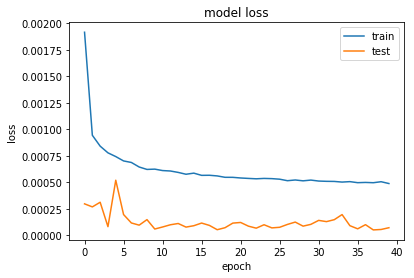

In [82]:
####################################################################################
# PASO 16: Realiza el entrenamiento de la red
num_epochs = 20
nb_epoch = 5
  
try:
  # ejecuta cada 'nb_epoch' hasta un total de 'num_epochs'
  for i in range(0, num_epochs, nb_epoch):        
    print('\r\n--------------------\r\nIniciando entrenamiento en epoch=',epoch_count)
    train_x = x_train.reshape(x_train.shape[0], num_in_steps, num_inputs)
    train_y = y_train.reshape(y_train.shape[0], num_out_steps * num_outputs)
    validation_x = x_validation.reshape(x_validation.shape[0], num_in_steps, num_inputs)
    validation_y = y_validation.reshape(y_validation.shape[0], num_out_steps * num_outputs)
    history = model.fit(train_x, train_y, epochs=nb_epoch, batch_size=batch_size, callbacks=callbacks_list, validation_data=(validation_x,validation_y), verbose=2, shuffle=True) 
    epoch_count += nb_epoch
except:
  print('Model fit Exception:', sys.exc_info()[0])



# visualizo el resultado de la ejecución de la celda actual
plt.plot(callbacks_list[1].loss[:])
plt.plot(callbacks_list[1].val_loss[:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

  


In [0]:
if ENABLE_GOOGLE_COLAB:
  files.download(file_weights)


# VERIFICACIÓN

##### Chequeo el resultado de aplicar el conjunto de test para obtener el par (Loss, Accuracy)

In [36]:
# Evalúa el funcionamiento con la partición de test
test_x = x_test.reshape(x_test.shape[0], num_in_steps, num_inputs)
test_y = y_test.reshape(y_test.shape[0], num_out_steps * num_outputs)            
scores = model.evaluate(test_x, test_y, verbose=2)
print('Model Loss: ', scores[0])  
print("Model Accuracy: %.2f%%" % (scores[1]*100))

Model Loss:  3.990169092740106e-05
Model Accuracy: 50.60%


##### Proceso todo el conjunto de test para obtener el error RMSE...

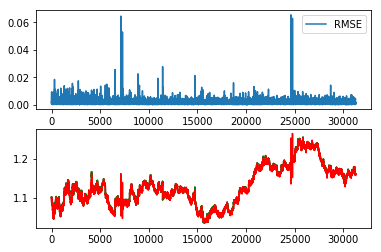

In [37]:
x_data = test_x
y_data = test_y

rmse = list()
inp,target,pred=list(),list(),list()
for sample in range(x_data.shape[0]):
    # Realizo predicción del primer conjunto de datos
    x = x_data[sample].reshape(1, num_in_steps, num_inputs)
    y = y_data[sample].reshape(1,num_outputs * num_out_steps)
    predictions = model.predict(x, batch_size=1,verbose=0)

    # deshago el scaling
    xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
    xy_values = scaler.inverse_transform(xy_values)
    xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
    xyhat_values = scaler.inverse_transform(xyhat_values)

    # Calculo el error RMSE
    rmse_val = math.sqrt(sk.mean_squared_error(xy_values[0,-(num_outputs * num_out_steps):], xyhat_values[0,-(num_outputs * num_out_steps):], multioutput = 'uniform_average'))
    rmse.append(rmse_val)
    inp.append(xy_values[0,-(num_outputs * num_out_steps)-1])
    target.append(xy_values[0,-(num_outputs * num_out_steps)])
    pred.append(xyhat_values[0,-(num_outputs * num_out_steps)])    

plt.plot(np.asarray(rmse))    
plt.legend(['RMSE'])


##### ...y las gráficas de resultado (Target vs Prediction)

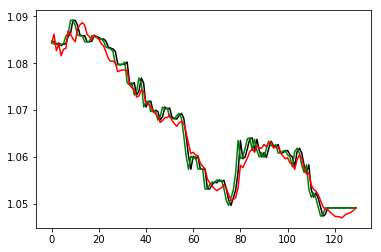

In [42]:
# visualizo los resultados anteriores en un rango dado
i,j = 70,200
plt.plot(np.asarray(inp).reshape((len(inp),))[i:j],color='black')
plt.plot(np.asarray(target).reshape((len(target),))[i:j],color='green')
plt.plot(np.asarray(pred).reshape((len(pred),))[i:j],color='red')
plt.legend(['x_test', 'y_target', 'y_predicted'])


### VERIFICACIÓN CON PREDICCIÓN REALIMENTADA

##### Como experimento, a partir de un dato de test, genero una predicción y la voy realimentando como entrada durante un nº de veces, para ver si la predicción se va desviando de la señal objetivo

@@@@ERROR curr_inp= 1.0729799999999998  denormalized_inp= 1.07298


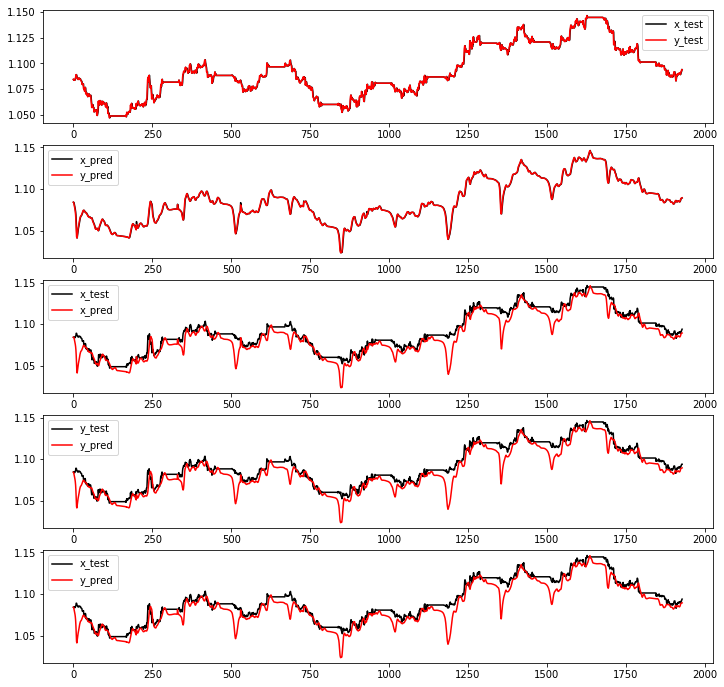

In [81]:
# Verificación con realimentación de predicción
# inicio sin ninguna predicción
ypred = np.nan
# establezco el periodo para realizar el test
initial_sample = trvl_samples + 1000
test_len = 1000
# hago una copia del dataframe original
dfraw = df.copy()
# creo listas para almacenar resultados predichos y objetivos
use_previous_lists = True
if not use_previous_lists or source_test is None:
 source_test, target_test, source_pred, pred = list(), list(), list(), list()
# flag para activar trazas de depuración de esta celda
print_logs = False

# para cada muestra de test
for sample in range(initial_sample, min(total_samples, initial_sample + test_len)):
  # obtengo referencia hasta la siguiente muestra de la actual en proceso
  s = sample + num_out_steps
    
  if print_logs:
    # imprimo traza para saber qué dato estoy procesando
    print('#############################')
    print('Evaluando muestra en ',sts_src.iloc[sample].name, ' close(t)=',sts_src.iloc[sample]['CLOSE(t)'], ' out(t+1)=',sts_src.iloc[sample]['out(t+1)'])  

  source_test.append(sts_src.iloc[sample]['CLOSE(t)'])
  target_test.append(sts_src.iloc[sample]['out(t+1)'])
  target.append(sts_src.iloc[s]['CLOSE(t)'])

  # 1. Selecciono hasta la muestra actual + timesteps a predecir y renombro la columna como CLOSE
  dfind = sts_src.iloc[:s+1].copy()
  dfind['CLOSE'] = dfind['CLOSE(t)']
  dfind=dfind[['CLOSE']]

  # si hay muestra predicha del paso anterior, la reinserto como una nueva muestra actual
  if not np.isnan(ypred):
    dfind.iloc[sample]['CLOSE'] = ypred
  curr_inp = dfind.iloc[sample]['CLOSE']

  if print_logs:
    print('---------- dfind ---------------')  
    print(dfind.tail(3))
    
  # 1. Obtiene el df con indicadores y crea una columna para la salida
  dfind = add_indicators(dfind, ['CLOSE'], ['bollWidthRel', 'bollR', 'atr', 'SMAx3'], add_applied=True)
  dfind['out']=dfind['CLOSE']
  
  if print_logs:
    print('---------- dfind + ind ---------------')  
    print(dfind.tail(3))

  # 2. Convierte el df para el entrenamiento supervisado y normalizado
  dfind = series_to_supervised(dfind, num_inputs, num_outputs, num_in_steps, num_out_steps)
  tvalues = dfind.values
  tvalues = tvalues.astype('float32')
  tscaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
  tvalues = tscaler.fit_transform(tvalues)
  dfind = pd.DataFrame(data=tvalues, columns=dfind.columns, index=dfind.index)
  if print_logs:
    print('---------- dfind dropna ---------------')  
    print(dfind.tail(3))

  # 3. Realizo predicción para la muestra actual
  tval = dfind.iloc[-1].values.reshape((1,dfind.shape[1]))
  x = tval[0,:num_inputs*num_in_steps].reshape((1, num_in_steps, num_inputs))
  y = tval[0,-num_outputs*num_out_steps:].reshape((1, num_outputs*num_out_steps))
  predictions = model.predict(x, batch_size=1,verbose=0)
  if print_logs:
    print('---------- predictions ---------------')  
    print(predictions)

  # 4. deshago el scaling para obtener la entrada y la predicción
  xy_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), y),axis=1)
  xy_values = tscaler.inverse_transform(xy_values)
  xyhat_values = np.concatenate((x.reshape(1, x.shape[1]*x.shape[2]), predictions),axis=1)
  xyhat_values = tscaler.inverse_transform(xyhat_values)
  
  # 5a. obtengo la entrada
  denormalized_inp = xy_values[0,-(num_outputs*num_out_steps)-1]
  if print_logs:    
    print('---------- input ---------------')  
    print('--> Input_close=', denormalized_inp)
  if curr_inp != denormalized_inp:
    print('@@@@ERROR curr_inp=', curr_inp, ' denormalized_inp=',denormalized_inp)
  
  source_pred.append(denormalized_inp)

  # 5b. obtengo salida predicha para realimentar el proceso
  ypred = xyhat_values[0,-num_outputs*num_out_steps]
  if print_logs:
    print('---------- result ---------------')  
    print('--> Predicted_close=', ypred)
  pred.append(ypred)

plt.figure(figsize=(12,12))    
plt.subplot(5,1,1)
plt.plot(np.asarray(source_test).reshape((len(source_test),)), color='black')
plt.plot(np.asarray(target_test).reshape((len(target_test),)), color='r')
plt.legend(['x_test', 'y_test'])
plt.subplot(5,1,2)
plt.plot(np.asarray(source_pred).reshape((len(source_pred),)), color='black')
plt.plot(np.asarray(pred).reshape((len(pred),)), color='r')
plt.legend(['x_pred', 'y_pred'])
plt.subplot(5,1,3)
plt.plot(np.asarray(source_test).reshape((len(source_test),)), color='black')
plt.plot(np.asarray(source_pred).reshape((len(source_pred),)), color='r')
plt.legend(['x_test', 'x_pred'])
plt.subplot(5,1,4)
plt.plot(np.asarray(target_test).reshape((len(target_test),)), color='black')
plt.plot(np.asarray(pred).reshape((len(pred),)), color='r')
plt.legend(['y_test', 'y_pred'])
plt.subplot(5,1,5)
plt.plot(np.asarray(source_test).reshape((len(source_test),)), color='black')
plt.plot(np.asarray(pred).reshape((len(pred),)), color='r')
plt.legend(['x_test', 'y_pred'])

